Data Cleaning
====
First we want to check the feasibility of using these smartwatches in this population, but even before we can do that we need to clean the data

### Pre-trial Entries
Some of the entries were made before the start of the study proper.

### Duplicates
Some entries were recorded twice by the smartwatches; either as user error or a fault with the watch.


In [1]:
"""
Preamble

"""
%load_ext autoreload
%autoreload 2

/home/mh19137/seaco_malaysia/ema/clean.py:189: UserWarning: Long catchup: not marking Meal at 2022-05-19 09:02:49 as catchup
  warnings.warn(


 Open ended catchup at 2022-02-11 20:02:05 ended by No response at 2022-02-12 08:02:11
 Open ended catchup at 2022-02-14 20:26:30 ended by No response at 2022-02-15 08:02:16
 Open ended catchup at 2022-04-19 08:01:14 ended by No catch-up at 2022-04-19 08:01:17
 Open ended catchup at 2022-06-27 15:53:14 ended by Catch-up start at 2022-06-27 15:54:06
 Open ended catchup at 2021-12-31 22:11:10 ended by No catch-up at 2022-01-01 08:01:15
 Open ended catchup at 2022-05-24 07:25:36 ended by Catch-up start at 2022-05-24 07:26:00
 Open ended catchup at 2022-03-21 08:01:57 ended by No catch-up at 2022-03-21 08:02:04
 Open ended catchup at 2022-03-07 18:33:30 ended by No catch-up at 2022-03-07 18:33:34
 Open ended catchup at 2022-03-07 18:37:08 ended by No catch-up at 2022-03-07 18:37:14
 Open ended catchup at 2022-03-07 19:29:23 ended by No response at 2022-03-08 08:02:56
 Open ended catchup at 2022-03-08 08:30:40 ended by No catch-up at 2022-03-08 08:31:08
 Open ended catchup at 2022-03-08 09:

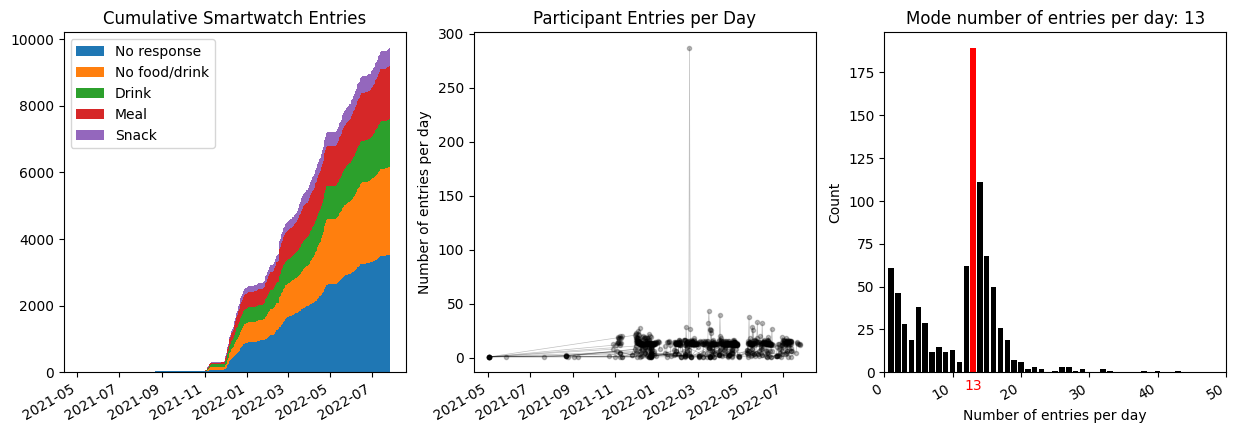

In [2]:
"""
Show the visualisations that we'll be using to clean the data

"""
import pandas as pd
import matplotlib.pyplot as plt
from ema import read, plotting, clean


def three_plots(meal_df: pd.DataFrame, path: str):
    """
    Make three plots from meal_info

    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    plotting.entry_time_hist(meal_df, cumulative=True, fig_ax=(fig, axes[0]))
    axes[0].set_title("Cumulative Smartwatch Entries")

    plotting.participant_entries_per_day(meal_df, fig_ax=(fig, axes[1]))
    axes[1].set_title("Participant Entries per Day")

    *_, mode = plotting.participant_entries_histogram(meal_df, fig_ax=(fig, axes[2]))
    axes[2].set_title(f"Mode number of entries per day: {mode}")

    fig.autofmt_xdate()
    fig.savefig(path)


def _data():
    """
    The smartwatch data before cleaning

    Catchup entries and markers are removed

    """
    meal_info = read.all_meal_info()

    # Remove catchup markers and entries
    meal_info = clean.remove_catchups(meal_info)

    return meal_info


three_plots(_data(), "img/before_cleaning.png")

Things to note:
- There's a long tail on the left histogram; there are a few entries way before the rest of them
- We can also see this in the middle plot
- There's also one participant entering loads of entries on the same day - we can see this in the middle plot
- There's quite a lot of days with not many entries (right plot, left of the red bar)

First we'll get rid of entries before the start of the trial
### Pre-trial Entries

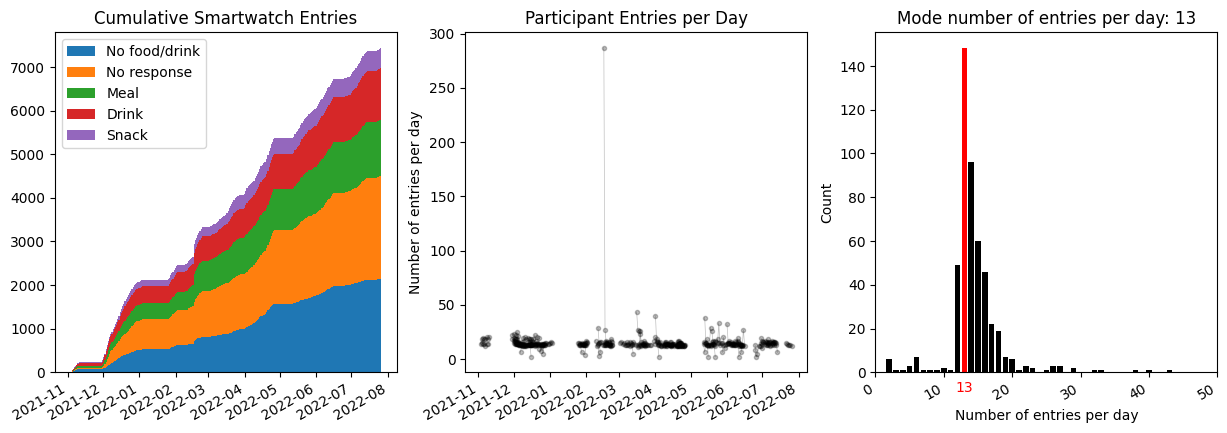

In [3]:
"""
Remove entries before the start of the trial, and also day 1 since this is incomplete

"""
import pandas as pd
import numpy as np


def remove_before(meal_df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove entries before the start of the trial

    """
    return meal_df[meal_df["delta"].dt.days >= 0]


def remove_day1(meal_df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove entries on day 1

    """
    return meal_df[meal_df["delta"].dt.days != 0]

def remove_after(meal_df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove entries after the end of the trial

    """
    return meal_df[meal_df["delta"].dt.days <= 7]


meal_info = remove_after(remove_day1(remove_before(_data())))

three_plots(meal_info, "img/removed_pre_trial.png")

Now:
- The long tail has disappeared
- The big spike is still there in the middle plot
- There are now fewer days with only a few entries

### Why remove entries on the first day of the study?
We think that this isn't a valid day (it will follow a different pattern to the other days), because it looks like there are far fewer events on the first day of the study

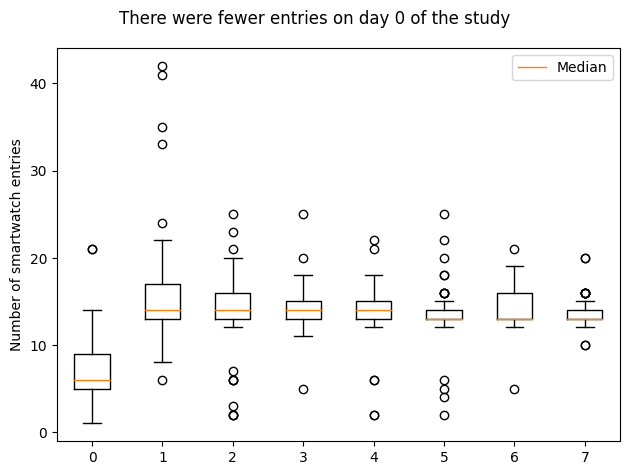

In [4]:
"""
Stacked histogram of entries by entry date

"""
# Re read to get a clean slate
meal_info = _data()

meal_info = remove_after(remove_before(meal_info))


# Remove duplicates - see the below cell
meal_info = meal_info[~clean.duplicates(meal_info)]


def boxplot(meal_df: pd.DataFrame, path: str, *, title: str = None):
    """
    Make a boxplot of the number of entries per day and save it

    Optionally specify a title

    """
    fig, axis = plt.subplots()
    occurrences_per_day = []
    for day in range(8):
        # Find entries on this day
        mask = (meal_df["delta"] > pd.Timedelta(days=day)) & (
            meal_df["delta"] < pd.Timedelta(days=day + 1)
        )
        df_slice = meal_df[mask]

        # Find how many entries each participant has
        _, occurrences = np.unique(df_slice["p_id"], return_counts=True)
        occurrences_per_day.append(occurrences)

    boxes = axis.boxplot(occurrences_per_day, showmeans=False)

    axis.set_xticks(range(1, 9), labels=range(8))
    axis.set_ylabel("Number of smartwatch entries")
    axis.legend(boxes["medians"], ["Median"])

    fig.suptitle(
        "There were fewer entries on day 0 of the study" if title is None else title
    )

    fig.tight_layout()
    fig.savefig(path)


boxplot(meal_info, "img/n_entries_per_day_boxplot.png")

In [5]:
"""
We can also do this showing only/exluding the No Responses

"""
# Commented these out to save plot space
# boxplot(
#     meal_info[meal_info["meal_type"] == "No response"],
#     "img/n_noresponses_per_day_boxplot.png",
#     title="No Responses per day",
# )
# boxplot(
#     meal_info[meal_info["meal_type"] != "No response"],
#     "img/n_responses_per_day_boxplot.png",
#     title="Excluding No Responses",
# )

'\nWe can also do this showing only/exluding the No Responses\n\n'

found 451 duplicates of 9726 entries


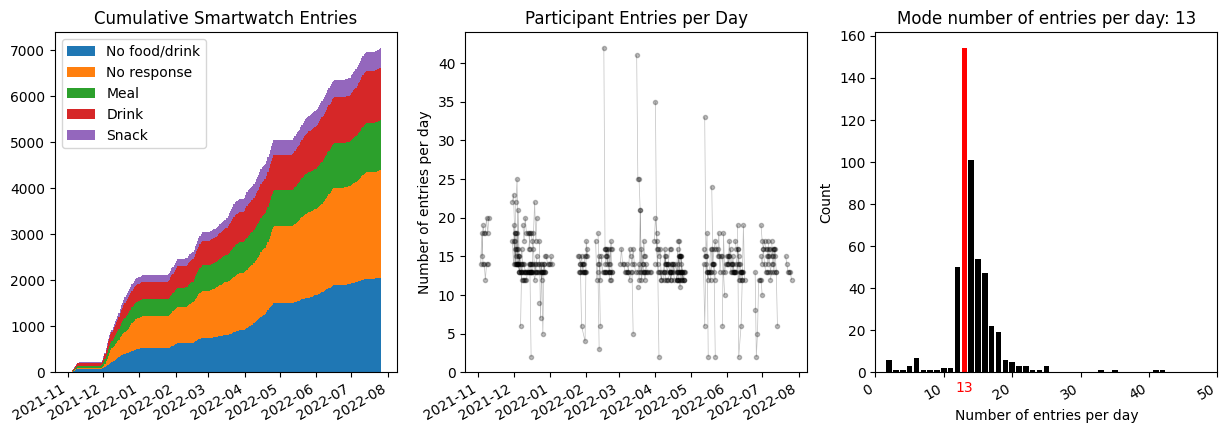

In [6]:
"""
Let's also remove duplicates

"""
# Re read to get a clean slate
meal_info = _data()

# Remove duplicates
duplicates = clean.duplicates(meal_info)
print(f"found {duplicates.sum()} duplicates of {len(meal_info)} entries")
meal_info = meal_info.loc[~duplicates]

# Let's do both
meal_info = _data()
meal_info = meal_info[~clean.duplicates(meal_info)]
meal_info = remove_after(remove_before(remove_day1(meal_info)))

three_plots(meal_info, "img/removed_duplicates.png")

Things to note:
- The big spike in the middle plot has gone away
- Some of the events with more entries in the right hand plot have gone away


Let's also check that we get the same result (that the graphs look the same) when we use the data cleaning library function:

plots are the same ✅


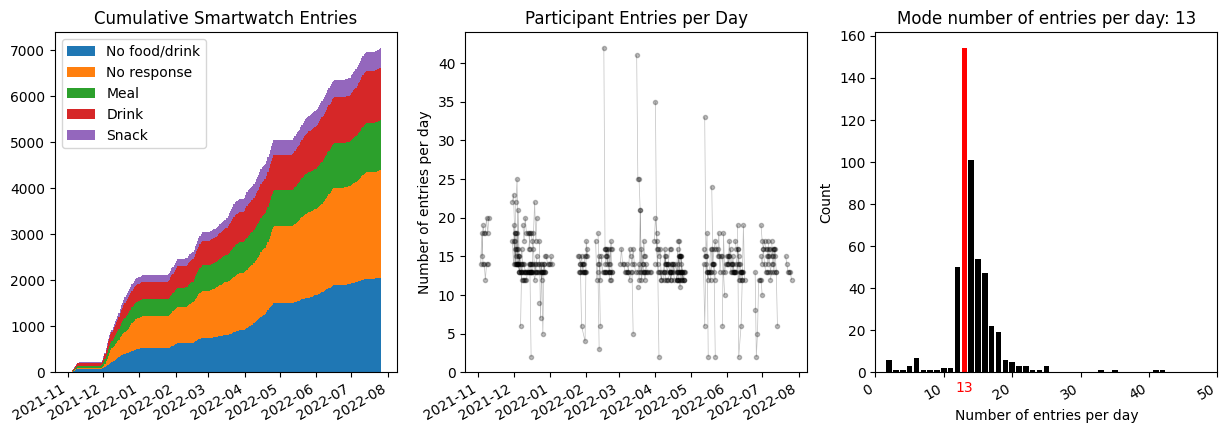

In [7]:
"""
Use my cleaning function to do all the above, and check the plot output is the same

"""

import os

meal_info = clean.clean_meal_info(read.all_meal_info(), keep_catchups=False)

tmp_path = "tmp.png"
try:
    three_plots(meal_info, tmp_path)
    assert (
        open(tmp_path, "rb").read() == open("img/removed_duplicates.png", "rb").read()
    )
    print("plots are the same \u2705")
    os.remove(tmp_path)

except AssertionError:
    print("plots are not the same \u274C")

The plots should be the same